# Monitoring

> Monitor different aspects of the model and training run

In [1]:
#| default_exp monitoring

In [2]:
# |export
import re
from argparse import Namespace
from collections import Counter

import lightning as L
import matplotlib.pyplot as plt
import wandb
from glom import glom
from lightning.pytorch.loggers import WandbLogger
from torch import nn

from slow_diffusion.fashionmnist import FashionMNISTDataModule
from slow_diffusion.training import get_tiny_unet

/home/jeremy/micromamba/envs/slow_diffusion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We want to make sure the model can be inspected

In [3]:
def test_run(callback):
    with wandb.init():
        wandb_logger = WandbLogger()
        dm = FashionMNISTDataModule(256, n_workers=7)
        dm.setup()
        model = get_tiny_unet()
        trainer = L.Trainer(
            max_epochs=1,
            callbacks=[callback],
            logger=WandbLogger(),
            precision="bf16-mixed",
            log_every_n_steps=1,
        )
        trainer.fit(model=model, datamodule=dm)

In [4]:
# |export
class MonitorCallback(L.Callback):
    """Log arbitrary properties in the training run, such as LR."""

    def __init__(self, gloms: dict[str, str]):
        super().__init__()
        if not gloms:
            raise ValueError
        self.gloms = gloms

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        args = Namespace(
            trainer=trainer,
            pl_module=pl_module,
            outputs=outputs,
            batch=batch,
            batch_idx=batch_idx,
        )
        for name, spec in self.gloms.items():
            self.log(name, glom(args, spec), on_step=True)

In [5]:
%%time
test_run(MonitorCallback({"lr": "trainer.optimizers.0.param_groups.0.lr"}))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jfisher40. Use `wandb login --relogin` to force relogin


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/jeremy/micromamba/envs/slow_diffusion/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name    | Type    | Params | Mode 
----------------------

Epoch 0: 100%|██████████████████| 235/235 [05:03<00:00,  0.77it/s, v_num=s51y]
Validation: |                                           | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████████████| 235/235 [05:20<00:00,  0.73it/s, v_num=s51y]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████████████| 235/235 [05:25<00:00,  0.72it/s, v_num=s51y]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
test_loss,▁
train_loss,█▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch,0
lr,0.0
test_loss,1.00017
train_loss,0.99471
trainer/global_step,234


CPU times: user 4min 24s, sys: 1min 4s, total: 5min 29s
Wall time: 5min 37s


In [11]:
model = get_tiny_unet()

In [13]:
zeros = 0
for _, params in model.named_parameters():
    zeros += (params == 0).sum()
zeros

tensor(23312)

In [14]:
# |exports
class CountDeadUnitsCallback(L.Callback):
    """Check for numeric underflow or overflow"""

    def __init__(self):
        super().__init__()

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        nans = 0
        zeros = 0
        for _, params in pl_module.named_parameters():
            nans += params.isnan().int().sum().item()
            zeros += (params == 0).sum().item()
        self.log("nans", nans, reduce_fx=max)
        self.log("zeros", zeros, reduce_fx=max)

In [15]:
%%time
test_run(CountDeadUnitsCallback())

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jeremy/micromamba/envs/slow_diffusion/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | unet    | Unet    | 185 M  | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
185 M     Trainable params
0         Non-trainable params
185 M     Total params
742.125   Total estimated model params size (MB)


Epoch 0: 100%|██████████████████████████████████████████| 235/235 [05:06<00:00,  0.77it/s, v_num=d9oj]
Validation: |                                                                   | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████████████████████████████████████| 235/235 [05:23<00:00,  0.73it/s, v_num=d9oj]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████████████████████████████████████| 235/235 [05:28<00:00,  0.71it/s, v_num=d9oj]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nans,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁
train_loss,█▂▁▁▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
zeros,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,0
nans,0.0
test_loss,0.99999
train_loss,0.99866
trainer/global_step,234


CPU times: user 4min 25s, sys: 1min 7s, total: 5min 32s
Wall time: 5min 40s


Check activation distribution metrics.

In [8]:
# |exports
class Stats:
    def __init__(self, label, module, log, live):
        self.label = label
        self.hook = module.register_forward_hook(self.append)
        self.log = log
        self.live = live
        self.means = []
        self.stds = []

    def append(self, module, _, activations):
        if not module.training:
            return
        activations = activations.cpu()
        mean = activations.mean().cpu().item()
        std = activations.std().cpu().item()
        if self.live:
            self.log(f"{self.label}:mean", mean)
            self.log(f"{self.label}:std", std)
        else:
            self.means.append(mean)
            self.stds.append(std)

    def plot(self, ax0, ax1):
        ax0.plot(self.means)
        ax1.plot(self.stds, label=self.label)

    def cleanup(self):
        self.hook.remove()


class StatsCallback(L.Callback):
    def __init__(
        self,
        mods: list[type[nn.Module]] | None = None,
        mod_filter: str | None = None,
        live=False,
    ):
        assert mods or mod_filter
        self.mods = []
        if mods is not None:
            self.mods.extend(mods)
        self.mod_filter = mod_filter
        self.mod_stats = []
        self.live = live

    def on_fit_start(self, trainer, pl_module):
        c = Counter()
        for mod in self.mods:
            cls_name = mod.__class__.__name__
            name = f"{cls_name}:{c.get(cls_name)}"
            s = Stats(name, mod, self.log, self.live)
            self.mod_stats.append(s)
            c.update((cls_name,))

        if self.mod_filter is not None:
            for name, mod in pl_module.named_modules():
                if re.match(self.mod_filter, name):
                    s = Stats(name, mod, self.log, self.live)
                    self.mod_stats.append(s)

    def plot(self, log=True):
        with plt.style.context("ggplot"):
            fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))
            ax0.set(title="Means", xlabel="Time Step", ylabel="Activation")
            ax1.set(title="STDs", xlabel="Time Step")
            for mod_stat in self.mod_stats:
                mod_stat.plot(ax0, ax1)
            fig.legend(loc=7)
            fig.subplots_adjust(right=0.75)
            if log:
                img = wandb.Image(fig)
                wandb.log({"stats": img})

    def cleanup(self):
        if not self.live:
            self.plot()
        for s in self.mod_stats:
            s.cleanup()

    def on_fit_end(self, trainer, pl_module):
        self.cleanup()

    def on_exception(self, trainer, pl_module, exception):
        self.cleanup()

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jeremy/micromamba/envs/slow_diffusion/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | unet    | Unet    | 185 M  | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
185 M     Trainable params
0         Non-trainable params
185 M     Total params
742.125   Total estimated model params size (MB)


Epoch 0: 100%|██████████████████| 235/235 [07:14<00:00,  0.54it/s, v_num=8wsm]
Validation: |                                           | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████████████| 235/235 [07:31<00:00,  0.52it/s, v_num=8wsm]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████████████| 235/235 [07:36<00:00,  0.51it/s, v_num=8wsm]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁
train_loss,█▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch,0
test_loss,1.00009
train_loss,1.00623
trainer/global_step,234


CPU times: user 12min 3s, sys: 2min 34s, total: 14min 38s
Wall time: 7min 49s


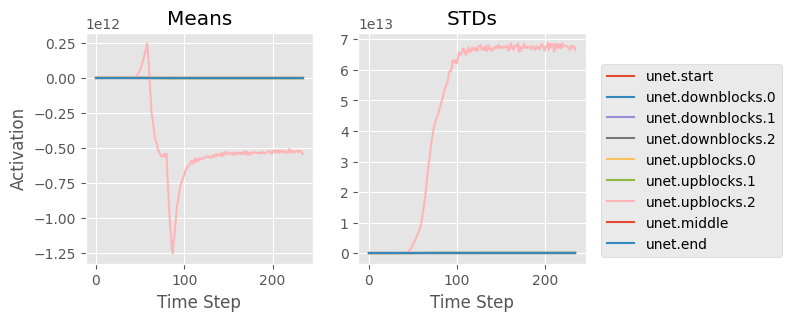

In [9]:
%%time
cb = StatsCallback(mod_filter=r"unet.(((down|up)blocks.\d+)|start|middle|end)(?!\.)")
test_run(cb)

You can see how _bad_ the training dynamics are initially

In [10]:
#| hide
import nbdev

nbdev.nbdev_export()